In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from sklearn.metrics import confusion_matrix, f1_score
from torchvision import transforms
import time
from torchvision import models
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import csv
import argparse
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer

## Class Dataset

In [2]:
class MusicGenreDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None, num_splits=10):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = self._make_dataset(self.root, self.class_to_idx)
        self.num_splits = num_splits

        # Initialize LabelBinarizer for one-hot encoding
        self.label_binarizer = LabelBinarizer()
        self.label_binarizer.fit(range(len(self.classes)))

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx):
        dataset = []
        for target in sorted(class_to_idx.keys()):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue

            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    dataset.append(item)

        return dataset

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]

        img = np.load(path)

        # Use one-hot encoding for the target
        target_one_hot = self.label_binarizer.transform([target])[0]

        # Ensure that target_one_hot has the correct length (num_classes)
        if len(target_one_hot) != 10:
            raise ValueError(f"The length of target_one_hot ({len(target_one_hot)}) does not match num_classes ({10}).")

        # Cast the target label to Long data type
        target_one_hot = torch.tensor(target_one_hot, dtype=torch.float32)  # or torch.int64

        return img, target_one_hot

## Class CNN-RNN

In [3]:
class CNNtoRNN(nn.Module):
    def __init__(self, num_classes, rnn_hidden_size, num_rnn_layers) -> None:
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 128, 5, padding=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(128, 128, 5, padding=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        # Size of the flattened CNN features, needs to be calculated based on the CNN output
        self.cnn_output_size = 32 * 160 * 128

        # RNN layers
        self.rnn = nn.GRU(input_size=self.cnn_output_size,
                          hidden_size=rnn_hidden_size,
                          num_layers=num_rnn_layers,
                          batch_first=True)

        # Linear and LogSoftmax layers
        self.fc = nn.Linear(rnn_hidden_size, num_classes)
        # self.log_softmax = nn.LogSoftmax(dim=-1) # LogSoftmax does not work with CrossEntropyLoss !!!!

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)

        # Flatten the CNN output for the RNN layer
        x = x.view(x.size(0), -1)

        # The RNN layer expects inputs of shape (batch, seq_len, features)
        # Since we don't have a sequence, we can treat the entire CNN output as one sequence
        # by adding an additional dimension with seq_len=1
        x = x.unsqueeze(1)

        # Apply the RNN layer
        x, _ = self.rnn(x)

        # Take the output for the last time-step
        x = x[:, -1, :]

        # Apply the final fully connected layer and LogSoftmax
        x = self.fc(x)

        return x

## CNN-RNN

Sequential(
  (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=582784, out_features=10, bias=True)
  (9): LogSoftmax(dim=-1)
)
Trainging on:  cuda


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]


Epoch 1/25, Train Loss: 19.0725, Train Accuracy: 0.1100, Val Loss: 2.2747, Val Accuracy: 0.0400


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]


Epoch 2/25, Train Loss: 1.9457, Train Accuracy: 0.4062, Val Loss: 2.1434, Val Accuracy: 0.2000


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 3/25, Train Loss: 1.0640, Train Accuracy: 0.7113, Val Loss: 2.9481, Val Accuracy: 0.6400


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Epoch 4/25, Train Loss: 0.3933, Train Accuracy: 0.9100, Val Loss: 3.8329, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 5/25, Train Loss: 0.2458, Train Accuracy: 0.9400, Val Loss: 3.8213, Val Accuracy: 0.7200


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch 6/25, Train Loss: 0.1344, Train Accuracy: 0.9750, Val Loss: 4.5071, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


Epoch 7/25, Train Loss: 0.1530, Train Accuracy: 0.9750, Val Loss: 4.6314, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.48it/s]


Epoch 8/25, Train Loss: 0.0851, Train Accuracy: 0.9888, Val Loss: 6.1318, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]


Epoch 9/25, Train Loss: 0.0815, Train Accuracy: 0.9875, Val Loss: 6.5531, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


Epoch 10/25, Train Loss: 0.0570, Train Accuracy: 0.9875, Val Loss: 6.5714, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch 11/25, Train Loss: 0.0444, Train Accuracy: 0.9938, Val Loss: 6.6740, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.41it/s]


Epoch 12/25, Train Loss: 0.0320, Train Accuracy: 0.9938, Val Loss: 7.2057, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch 13/25, Train Loss: 0.0654, Train Accuracy: 0.9938, Val Loss: 6.5303, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.26it/s]


Epoch 14/25, Train Loss: 0.0294, Train Accuracy: 0.9975, Val Loss: 6.7861, Val Accuracy: 0.7600


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Epoch 15/25, Train Loss: 0.0302, Train Accuracy: 0.9975, Val Loss: 7.7142, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


Epoch 16/25, Train Loss: 0.0212, Train Accuracy: 0.9962, Val Loss: 7.7943, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s]


Epoch 17/25, Train Loss: 0.0140, Train Accuracy: 0.9975, Val Loss: 7.9609, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Epoch 18/25, Train Loss: 0.0406, Train Accuracy: 0.9988, Val Loss: 8.2059, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]


Epoch 19/25, Train Loss: 0.0784, Train Accuracy: 0.9938, Val Loss: 6.7207, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]


Epoch 20/25, Train Loss: 0.0400, Train Accuracy: 0.9950, Val Loss: 6.4042, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


Epoch 21/25, Train Loss: 0.0341, Train Accuracy: 0.9938, Val Loss: 7.3740, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


Epoch 22/25, Train Loss: 0.0388, Train Accuracy: 0.9975, Val Loss: 7.5279, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.89it/s]


Epoch 23/25, Train Loss: 0.0276, Train Accuracy: 0.9988, Val Loss: 7.1757, Val Accuracy: 0.8000


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


Epoch 24/25, Train Loss: 0.0690, Train Accuracy: 0.9962, Val Loss: 7.7700, Val Accuracy: 0.7600


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


Epoch 25/25, Train Loss: 0.0508, Train Accuracy: 0.9938, Val Loss: 6.2563, Val Accuracy: 0.8000


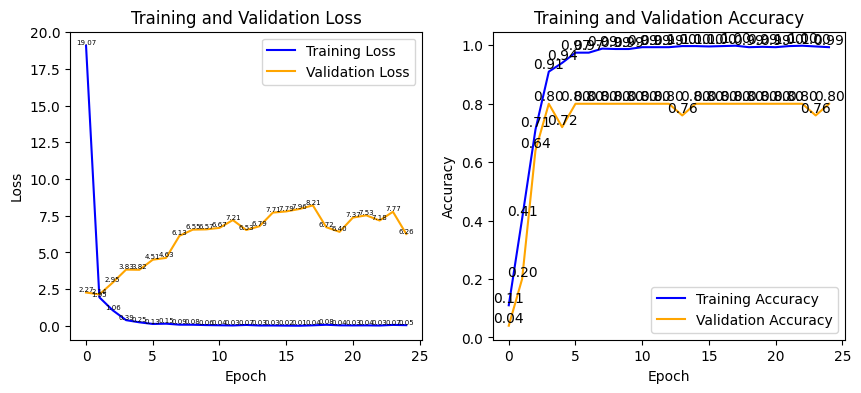

Testing on:  cuda


Testing:   0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [4]:
# Parameters
num_classes = 10  # Assume there are 10 music genre classes
batch_size = 30
root = "data/gtzan/data_MEL_640"  # Replace with the correct path
# Parameters
learning_rate = 0.0001
num_epochs = 25
timestr = time.strftime("%Y%m%d-%H%M%S")
# Chose the model to use
model_chosen = "custom_1"
# Choose if doing Train and Test or ONLY TEST
num_rnn_layers = 1
rnn_hidden_size = 96
train = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_info = {
    'parameter': 'value',
    'lr': f'{learning_rate:.8f}',
    'number of epochs': num_epochs,
    'base_model': model_chosen,
    'device': str(device),
    'rnn_hidden_size': 96,
    'num_rnn_layers': 1
}

trained = False

# Transformations for spectrogram images
transform = transforms.Compose([
    transforms.ToTensor()
])

    
dataset = MusicGenreDataset(root, transform=transform)
dataset2 = MusicGenreDataset(root, transform=transform)


show_first = False
if show_first:

    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(dataset2, batch_size=25, shuffle=False)

    # Iterate over the DataLoader and visualize the first 10 images
    for batch in dataloader:
        images, labels = batch

        for img in images:
            print(img.size())

        break  # Break after the first batch to show only the first 10 images

# Split between training, validation, and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if model_chosen == "alexnet":
    # Initialize the model AlexNet with dropout
    model = models.alexnet(pretrained=True)
    # print(model)
    model.classifier[6] = nn.Sequential(
        nn.Dropout(0.2),  # Add dropout with a specified probability
        nn.Linear(1000, num_classes),
    )
elif model_chosen == "googlenet":
    # Initialize the model GoogLeNet with dropout
    model = models.googlenet(pretrained=True)
    print(model)
    model.fc = nn.Sequential(
        nn.Dropout(0.2),  # Add dropout with a specified probability
        nn.Linear(1024, num_classes),
    )
elif model_chosen == "custom_1":
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling dopo il primo layer di convoluzione

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling dopo il secondo layer di convoluzione

        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(157 * 29 * 128, 10),
        nn.LogSoftmax(dim=-1)
    )
elif model_chosen == "custom_2":
    
    model = CNNtoRNN(num_classes, num_rnn_layers, rnn_hidden_size)
    
    
print(model)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

if (train):

    trained = True

    print("Trainging on: ", device)

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            # print(f"Input shape:{inputs.size()}")
            # print(f"Labels shape:{labels}")
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Adds a channel dimension

            # print(inputs[0])

            # HERE = inputs[0]

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"Output shape:{outputs.size()}")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            # Update this line to use one-hot encoded labels
            total_train += labels.size(0)
            correct_train += (predicted == torch.argmax(labels, dim=1)).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)
        model_info[f"train loss epoch " + str(epoch)] = f'{average_train_loss:.4f}'
        model_info[f"train accuracy epoch " + str(epoch)] = f'{train_accuracy:.4f}'

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in tqdm(val_loader, desc="Validation"):
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                inputs_val = inputs_val.unsqueeze(1)  # Adds a channel dimension

                outputs_val = model(inputs_val)
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == torch.argmax(labels_val, dim=1)).sum().item()


        average_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)
        model_info[f"val loss epoch " + str(epoch)] = f'{average_val_loss:.4f}'
        model_info[f"val accuracy epoch " + str(epoch)] = f'{val_accuracy:.4f}'

        # save the model
        newpath = "models/" + model_chosen + "_" + timestr
        if not os.path.exists(newpath):
            os.makedirs(newpath)

        model_name = str(timestr) + "_" + str(epoch) + ".pth"
        # Save the trained model
        torch.save(model.state_dict(), 'models/' + model_chosen + "_" + timestr + '/' + model_name)

        # Print training and validation metrics for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
                f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    model_name = timestr + ".pth"
    # Save the trained model
    torch.save(model.state_dict(), 'models/last.pth')

    # Plotting the training and validation losses
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # # Annotate each point with its exact value
    # for i, value in enumerate(train_losses):
    #     plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=5)

    # for i, value in enumerate(val_losses):
    #     plt.text(i, value, f'{value:.2f}', ha='center', va='bottom',fontsize=5)

    # Plotting the training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # # Annotate each point with its exact value
    # for i, value in enumerate(train_accuracies):
    #     plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

    # for i, value in enumerate(val_accuracies):
    #     plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

    save_fig_name = timestr + ".png"
    plt.savefig("save/" + model_chosen + "_" + save_fig_name)
    plt.savefig("models/" + model_chosen + "_" + timestr + "/" + save_fig_name)
    plt.show()

# Test the model
# Load the saved model state
model.load_state_dict(torch.load('models/last.pth'))

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Testing on: ", device)
model = model.to(device)

model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        inputs = inputs.unsqueeze(1)  # Adds a channel dimension

        optimizer.zero_grad()
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        # Update this line to use one-hot encoded labels
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')
model_info["accuracy"] = f'{accuracy:.4f}'

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Calculate F1 score
f1 = f1_score(all_labels, all_predicted, average='weighted')

# Add confusion matrix and F1 score to the model_info dictionary
model_info['confusion_matrix'] = conf_matrix.tolist()  # Convert to list for JSON serialization
model_info['f1_score'] = f1

if trained:
    # Save the model information in a CSV file
    csv_file_path = "models/" + model_chosen + "_" + timestr + "/" + "results.csv"
else:
    csv_file_path = "last.csv"

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    for key, value in model_info.items():
        # if isinstance(value, list):
        #     csv_writer.writerow([key] + value)
        # else:
        csv_writer.writerow([key, value])